Test the CNN Multigrid on a manufactured Poisson problem: f(x,y) = C\*sin(k\*pi\*x)\*sin(l\*pi\*y)

Change the stop criterion as the relative norm of residual, test the convergence by early termination

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 1] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        Return: error array with size of (num_sweeps_down,)
        '''
        self.v, e_array = self.jac.jacobi_convolution(self.v, self.f, n_iter=num_sweeps_down)
        return e_array


In [3]:
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        # Problem parameters
        C = 5.0
        k = 1
        l = 2

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []
        
        u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)  # exact solution
        self.u_exact = torch.from_numpy(u_exact.reshape(1,1,n+1, n+1))

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = C*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0

        f_res = F.conv2d(f_res, restriction_kernel.view(1, 1, 3, 3), stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        _, _, image_size, _ = v.shape
        new_size = 2 * image_size - 1
        v = F.interpolate(v, size=new_size, mode='bilinear', align_corners=True)
        level = np.where(self.n_arr == new_size-1)[0][0]
        return self.grids[level].jac.reset_boundary(v)

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].Relax(n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = 4*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].Relax(n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 1e-6
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_arr_Vcycle = [1]
        res_arr_Vcycle = [1]
        rel_res = 1
        relative_res_arr_Vcycle = [rel_res]
        fabs = torch.sqrt(torch.sum(self.grids[0].f[:, :, 1:-1, 1:-1] ** 2)).item()
        while (n_Vcycle<100):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            rel_res = res/fabs
            relative_res_arr_Vcycle.append(rel_res)
            print(e_Vcycle, res, rel_res)
            n_Vcycle += 1

        print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle, relative_res_arr_Vcycle

1.0 0.03389986604452133 0.2187087694565865
0.17577369945410468 0.007548288907855749 0.04869862837722734
0.03635106376521935 0.0017092111520469189 0.011027166517847357
0.007772914630910362 0.0003934972337447107 0.002538691322964242
0.0016782910719952793 9.241348743671551e-05 0.0005962159287571059
0.00036387270058001653 2.2170692318468355e-05 0.00014303669603309417
7.918183724152143e-05 5.42413727089297e-06 3.499442700813656e-05
1.7253408166903046e-05 1.3923835240348126e-06 8.98311771360214e-06
3.814712173380854e-06 4.6978402679087594e-07 3.03086408290978e-06
8.901136038443761e-07 3.367976546542195e-07 2.1728876600441098e-06
4.4783706525080684e-07 3.1361651053885e-07 2.023331921463614e-06
3.1380535810248376e-07 3.3288245049334364e-07 2.1476282834120046e-06
2.5252541423373767e-07 3.2180992093344685e-07 2.0761926231165837e-06
1.8755126280006252e-07 3.204483505214739e-07 2.0674082996345967e-06
2.909436919191655e-07 3.1482377949032525e-07 2.0311207518511304e-06
2.2169441607759145e-07 3.21014

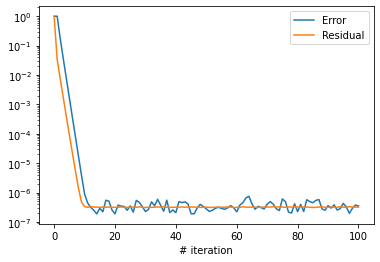

In [4]:
# Multigrid implementation
n = 2**6
prob_mg = Multigrid(n)

e_arr_Vcycle, res_arr_Vcycle, relative_res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
#plt.plot(relative_res_arr_Vcycle, label='Relative residual')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

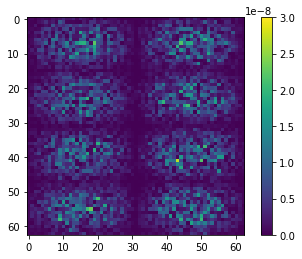

In [10]:
# Residual plots (except for boundaries)
residual = prob_mg.grids[0].f-prob_mg.grids[0].Knet(prob_mg.grids[0].v)
plot.plot_field(torch.abs(residual[:, :, 1:-1, 1:-1]),limit=[0,3e-8])

1.0 0.15314249694347382
0.49698589338721577 0.15130721032619476
0.3293226608374428 0.14949393272399902
0.24549713303538043 0.14770236611366272
0.19520670235008108 0.14593227207660675
0.16168379840624733 0.14418339729309082
0.1377423406533724 0.14245547354221344
0.11978928018057962 0.1407482773065567
0.10582851979718837 0.13906152546405792
0.09466233190501215 0.1373949944972992
0.08552857473824628 0.13574843108654022
0.07791914439095453 0.1341215819120407
0.07148226262649879 0.13251425325870514
0.06596667567894438 0.1309261918067932
0.06118810899052981 0.12935714423656464
0.057008393232457565 0.1278069168329239
0.05332182535249823 0.12627525627613068
0.05004623592665561 0.12476194649934769
0.047116722264550784 0.1232667863368988
0.04448136826020452 0.12178952991962433
0.04209814938586197 0.12032999098300934
0.0399326937607902 0.11888793855905533
0.037956590374739904 0.11746316403150558
0.0361461686586659 0.11605546623468399
0.03448154553403121 0.11466463655233383
0.03294590628202105 0.1

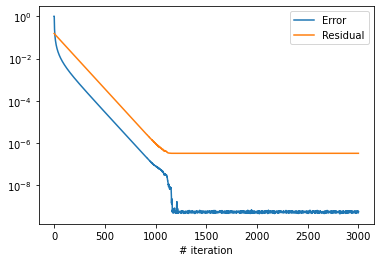

In [6]:
n = 2**6
prob_jac = Multigrid(n)
EPS = 1e-12
n_jacobi = 0
prob_jac.grids[0].v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
e_jacobi = 1
e_arr_jacobi = [e_jacobi]
res_arr_jacobi = []
while (n_jacobi < 3000):
    [e_jacobi] = prob_jac.grids[0].Relax(1)
    e_arr_jacobi.append(e_jacobi)
    residual = prob_jac.grids[0].f-prob_jac.grids[0].Knet(prob_jac.grids[0].v)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr_jacobi.append(res)
    print(e_jacobi, res)
    n_jacobi += 1

print("Solution converges after", n_jacobi, "Weighted Jacobi iterations with relative error of", e_jacobi)

plt.plot(e_arr_jacobi, label='Error')
#plt.plot(relative_res_arr_Vcycle, label='Relative residual')
plt.plot(res_arr_jacobi, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

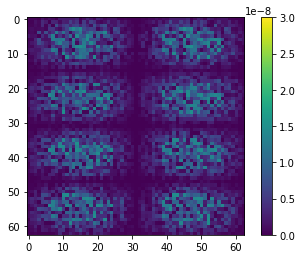

In [9]:
# Residual plots (except for boundaries)
residual_jac = prob_jac.grids[0].f-prob_jac.grids[0].Knet(prob_jac.grids[0].v)
plot.plot_field(torch.abs(residual_jac[:, :, 1:-1, 1:-1]),limit=[0,3e-8])